In [1]:
import copy
import sys
sys.path.insert(0, "../../")
from classes.atom_classes.atom import Atom
from classes.atom_classes.atom_file_handler import Atom_File_handler
from classes.atom_classes.atom_collection import Atom_Collection
from classes.atom_classes.atom_collection_plotter import Animator, Atom_Collection_Plotter
from classes.calculators.lennardjones import LJGauss
import matplotlib.pyplot as plt
from classes.kmeans import KMeans
import numpy as np

In [2]:
def custom_metric(u, v):
    print(v-u)
    return v-u

class PairDistances():
    def __init__(self, color='C1'):
        self.xwidth = 0.5
        self.color = color
        self.bin_edges = np.arange(0,7.01,self.xwidth)
        self.bin_centers = (self.bin_edges[:-1] + self.bin_edges[1:]) /2
    
    def descriptor(self,atom_cols):
        result = np.zeros(shape=(len(atom_cols), 12, 14))
        for i, atom_col in enumerate(atom_cols):
            atom_positions = atom_col.positions
            diffs = atom_positions[np.newaxis, :, :] - atom_positions[:, np.newaxis, :]
            dists = np.linalg.norm(diffs, axis=-1)
            for j, dist in enumerate(dists):
                bars, _ = np.histogram(dist,self.bin_edges)
                result[i][j] = bars
        return result

    def draw(self,pos,ax):
        vector = self.descriptor(pos)
        ax.bar(self.bin_centers,vector,width=0.8 * self.xwidth,color=self.color)
        ax.xaxis.set_major_locator(plt.MultipleLocator(1.0))
        ax.set_ylim([0,20.1])
        ax.set_title(self.__class__.__name__)

class Atom_Plotter(Animator):
    def __init__(self, default_cols=("C0", "C1"), markersize=50, scale_with_mass=False, alpha=1) -> None:
        super().__init__(default_cols, markersize, scale_with_mass, alpha)
    
    def __call__(self, atom_col, ax=None, plot_cell=False):
        return super().__call__(atom_col, ax, plot_cell)

    def plot_atom_col(self, atom_col):
        ax = atom_col.plot_axes
        plot_elems = []
        if atom_col.plot_elems["atoms"] is None:
            for position, frozen, label in zip(atom_col.positions, atom_col.frozens, atom_col.label):
                p = ax.plot(position[0], position[1], "o", c=f"C{label}", ms=self.markersize, alpha=self.alpha, markeredgecolor="k")[0]
                plot_elems.append(p)
        else:
            for position, plot_elem in zip(atom_col.positions, atom_col.plot_elems["atoms"]):
                plot_elem.set_data(position[0], position[1])
            plot_elems = atom_col.plot_elems["atoms"]
        return plot_elems



In [3]:
pair_distances = PairDistances()
atom_writer = Atom_File_handler()
relaxed_cols = []
for i in range(3):
    relaxed_cols += atom_writer.load_atom_collections(filename=f"../exercise 38/relaxed_structs{i}")

pair_dists = pair_distances.descriptor(atom_cols=relaxed_cols)
reshaped_pair_dists = pair_dists.reshape(12*len(relaxed_cols), 14)
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(data=reshaped_pair_dists, init_mus=np.array([reshaped_pair_dists[np.random.randint(0, len(reshaped_pair_dists), 1)] for _ in range(n_clusters)]).squeeze(1))

In [4]:
for atom_col,pair_dist in zip(relaxed_cols, pair_dists):
    labels = kmeans.predict(pair_dist)
    atom_col.label=labels

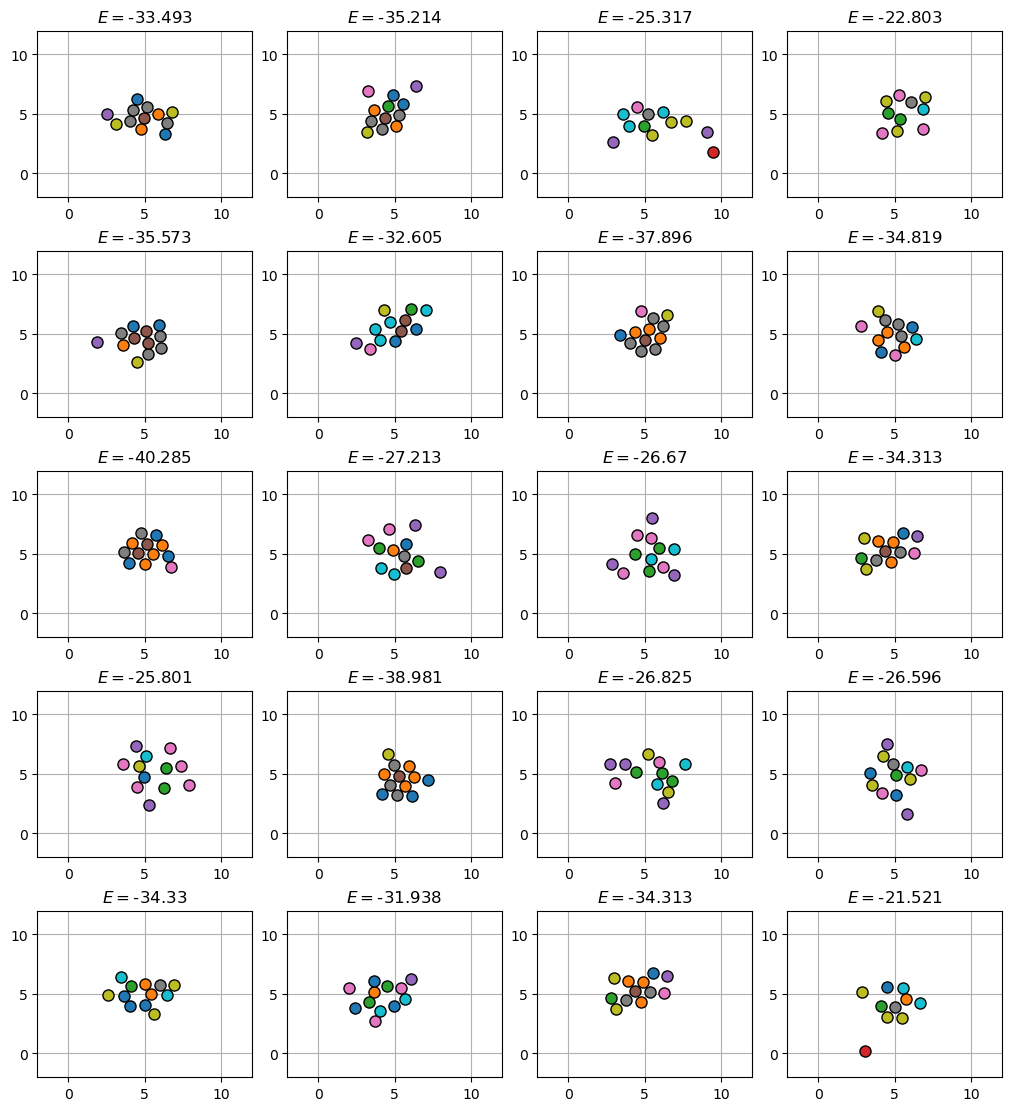

In [5]:
fig, axs = plt.subplots(5,4, figsize=(10,11), layout="constrained")
atom_plotter = Atom_Plotter(markersize=8)

indices = []
plotted_cols = []
plot_num = 0
while plot_num < 20:
    index = np.random.randint(0, len(relaxed_cols), 1)[0]
    if index not in indices:
        rel_col = relaxed_cols[index]
        plotted_cols.append(rel_col)
        ax = axs.flatten()[plot_num]
        ax.grid()
        #ax.set_aspect("equal")
        ax.set_xlim([-2.0, 12.0])
        ax.set_ylim([-2.0, 12.0])
        atom_plotter(atom_col=rel_col, ax=ax)
        ax.set_title(r"$E=$"+f"{round(rel_col.get_potential_energy(),3)}")
        rel_col.reset_plot_axes()
        plot_num+=1

In [6]:
from classes.regression.regressers import ridge_regressor, pol_kernel_regressor
n_clusters = 10
y_data = np.zeros(shape=(len(relaxed_cols),1))
X_data = np.zeros(shape=(len(relaxed_cols), n_clusters))

for i, atom_col in enumerate(relaxed_cols):
    y_data[i] = atom_col.get_potential_energy()
    X_data[i] = np.array([len(np.argwhere(atom_col.label == i)) for i in range(n_clusters)])

In [7]:
regressor = ridge_regressor(x_data=X_data, y_data=y_data.T[0], N_deg=1, lamb=1e-5)
pol_regressor = pol_kernel_regressor(x_data=X_data, y_data=y_data.T[0], N_deg=1, lamb=1e-5)

In [8]:
class local_LJGenergy(LJGauss):
    def __init__(self, gauss_sigma2=0.02, gauss_eps=1, r0=1.7):
        super().__init__(gauss_sigma2, gauss_eps, r0)
    
    def __call__(self, atom_col):
        atom_positions =  atom_col.positions
        diff = atom_positions[np.newaxis, :, :] - atom_positions[:, np.newaxis, :]
        r = np.sqrt(np.sum(diff**2, axis=-1))
        np.fill_diagonal(r, np.inf)
        return 0.5*np.sum(super().__call__(r), axis=0)

In [9]:
s = local_LJGenergy()
np.sum(s(relaxed_cols[0]))

-26.90009858302494

In [25]:
labelsShaped = np.array([atom_col.label for atom_col in relaxed_cols])
Epots = np.array([atom_col.get_potential_energy() for atom_col in relaxed_cols])
positions_in_file = np.array([atom_col.positions for atom_col in relaxed_cols])

(300, 10)
[-3.1231352  -3.77228892 -2.74459835 -0.17216985 -1.2805602  -2.98613099
 -2.09958438 -3.08492075 -2.22456222 -2.49761118]
[-0.01321869 -0.54527925 -3.14248656 -2.80012905 -1.63619834 -2.34078131
 -2.67823888 -3.49440892 -3.34384032 -0.55083257 -3.21809845 -3.13658625]
-26.90034086296596


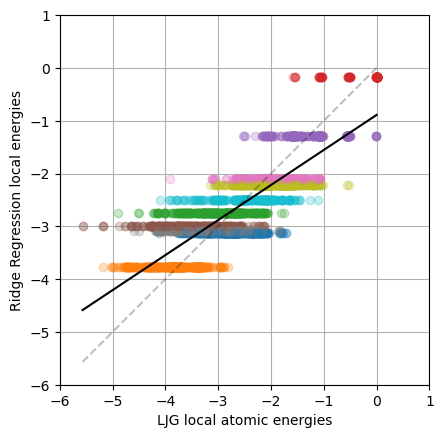

In [26]:
from scipy.spatial.distance import pdist, squareform

Xmatrix = np.array([np.histogram(labels, bins=np.arange(0, 10+1, 1))[0] for labels in labelsShaped])
Ematrix = np.array(Epots)

print(Xmatrix.shape)
eps = np.linalg.inv( Xmatrix.T @ Xmatrix + 0.1*np.identity(Xmatrix.shape[1]) ) @ Xmatrix.T @ Ematrix
print(eps)
def getLocalEnergies(pos, potentialFunc) : 
    return np.array( ( [np.sum(0.5*potentialFunc._V(np.delete( squareform(pdist(pos))[i], i) )) for i, _ in enumerate(pos) ]))

print(getLocalEnergies(positions_in_file[0], LJGauss()))
print(Ematrix[0])

clusterEnergies = []
ljg = LJGauss()

for pos, labels in zip(positions_in_file, labelsShaped) : 
    clusterEnergies.append( getLocalEnergies(pos, ljg) )


from scipy.optimize import curve_fit

def lin(E, A, B) : 
    return A*E+B

fig, ax = plt.subplots() 

#for clusterEnergy, labels in zip(clusterEnergies, labelsShaped) : 
#    for label in labels : 
#        ax.plot(clusterEnergy[label], eps[label], 'o', color=f'C{label}')

clustEns = []
epsilonLabels = []

for clusterEnergy, labels in zip(clusterEnergies, labelsShaped): 
    for i, label in enumerate(labels):  # Match index 'i' with local energy
        clustEns.append(clusterEnergy[i])
        epsilonLabels.append(eps[label])
        ax.plot(clusterEnergy[i], eps[label], 'o', color=f'C{label}', alpha=0.25)

popt, pcov = curve_fit(lin, clustEns, epsilonLabels, p0=[1,1])

clustEnsLin = np.linspace(min(clustEns), max(clustEns), 10000)
epsLin = lin(clustEnsLin, popt[0], popt[1])
ax.plot(clustEnsLin, epsLin, 'k-')
ax.plot(clustEnsLin, clustEnsLin, 'k--', alpha=0.25)

ax.set_xlabel("LJG local atomic energies")
ax.set_ylabel("Ridge Regression local energies")
ax.set_aspect('equal')
ax.set_ylim(-6, 1)
ax.set_xlim(-6, 1)
ax.grid()


In [15]:
betas = np.linalg.inv(X_data.T @ X_data + 1e-5*np.eye(X_data.shape[1]))@ X_data.T @ y_data
print(betas)
real_local_energies = []
fitted_local_energies = []
cols = []
local_energy_calculator = local_LJGenergy()
for atom_col in relaxed_cols:
    real_local_energies.append(local_energy_calculator(atom_col=atom_col))
    atom_col_betas = []
    atom_col_colors = []
    for label in labels:
        atom_col_betas.append(betas[label,0])
        atom_col_colors.append(f"C{label}")
    cols.append(atom_col_colors)
    fitted_local_energies.append(atom_col_betas)

[[-3.12316059]
 [-3.77250684]
 [-2.74479258]
 [-0.17206312]
 [-1.2804162 ]
 [-2.98650464]
 [-2.09953255]
 [-3.0847896 ]
 [-2.22449797]
 [-2.49789246]]


ValueError: s must be a scalar, or float array-like with the same size as x and y

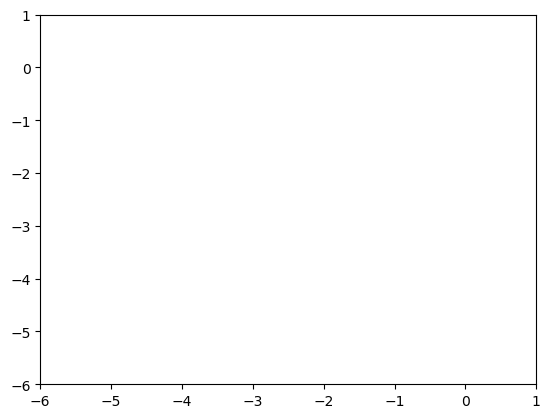

In [19]:
fig, ax = plt.subplots()
ax.set_xlim([-6,1])
ax.set_ylim([-6,1])

ax.scatter(np.array(real_local_energies).flatten(), np.array(fitted_local_energies).flatten(), 'o', c=np.array(cols).flatten(), alpha=0.1)

#for real_local, fitted_local, col in zip(real_local_energies, fitted_local_energies, cols):
#    ax.plot(real_local, fitted_local, 'o', c="C0", alpha=0.1)

In [ ]:
fitted_local_energies

[-3.7725068389038117,
 -3.0847896039996883,
 -3.7725068389038117,
 -3.0847896039996883,
 -2.9865046386490914,
 -2.224497968708298,
 -2.4978924606570603,
 -2.099532546502595,
 -2.224497968708298,
 -3.1231605920924856,
 -2.4978924606570603,
 -2.744792584726442,
 -3.7725068389038117,
 -3.0847896039996883,
 -3.7725068389038117,
 -3.0847896039996883,
 -2.9865046386490914,
 -2.224497968708298,
 -2.4978924606570603,
 -2.099532546502595,
 -2.224497968708298,
 -3.1231605920924856,
 -2.4978924606570603,
 -2.744792584726442,
 -3.7725068389038117,
 -3.0847896039996883,
 -3.7725068389038117,
 -3.0847896039996883,
 -2.9865046386490914,
 -2.224497968708298,
 -2.4978924606570603,
 -2.099532546502595,
 -2.224497968708298,
 -3.1231605920924856,
 -2.4978924606570603,
 -2.744792584726442,
 -3.7725068389038117,
 -3.0847896039996883,
 -3.7725068389038117,
 -3.0847896039996883,
 -2.9865046386490914,
 -2.224497968708298,
 -2.4978924606570603,
 -2.099532546502595,
 -2.224497968708298,
 -3.1231605920924856,
 -2